# CIS 5450 Final Project

# Introduction

For our big data analysis final project, we wanted to explore the effect that earnings report results have on the price movement of a stock in the US stock market. And of course, we also wanted to predict this movement as best as we could. To do this, we'll merge datasets for earnings and dates on symbol and price so that we can analyze the associations between earnings and price for the same stock on the same earnings date. Later on, we'll include the the spy dataset to adjust returns to the market as a whole, and we use the spy to represent this.

Throughout this notebook, we'll take you through our process of data collection, exploratory data analysis, data cleaning, modeling, and evaluation.


Dataset: https://www.kaggle.com/datasets/tsaustin/us-historical-stock-prices-with-earnings-data

In [174]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, confusion_matrix,
    mean_squared_error, mean_absolute_error, classification_report, roc_auc_score
)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, classification_report,
    precision_recall_curve
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## Data Loading

We'll load two key datasets:
1. **Earnings data** - Contains information about earnings announcements, including dates, actual EPS, consensus EPS, and announcement timing
2. **Price data** - Contains historical stock prices including open, high, low, close, and volume

These datasets will be merged to analyze the relationship between earnings announcements and subsequent price movements.

Note that we assume the dataset is loaded into the `./datasets`. This is because our dataset is extremely large, as the `prices` data (`stock_prices_latest.csv`) is roughly 2 gigabytes. For anyone looking to run this notebook, our recommendation is to download the kaggle dataset manually along with the notebook and run it locally to avoid the hassle of uploading the massive dataset. 

In [ ]:
# Load datasets
prices = pd.read_csv(
    "./datasets/stock_prices_latest.csv", # Assume data is in this path
    parse_dates=["date"],
    dtype={"symbol": str}
)
earnings = pd.read_csv(
    "./datasets/earnings_latest.csv",
    parse_dates=["date"],
    dtype={"symbol": str, "announce_time": str}
)

In [139]:
display(prices.shape)
display(prices.head())
display(prices.columns)

(24395016, 9)

,symbol,date,open,high,low,close,close_adjusted,volume,split_coefficient
0,MSFT,2016-05-16,50.80,51.96,50.75,51.83,49.7013,20032017,1.0
1,MSFT,2002-01-16,68.85,69.84,67.85,67.87,22.5902,30977700,1.0
2,MSFT,2001-09-18,53.41,55.00,53.17,54.32,18.0802,41591300,1.0
3,MSFT,2007-10-26,36.01,36.03,34.56,35.03,27.2232,288121200,1.0
4,MSFT,2014-06-27,41.61,42.29,41.51,42.25,38.6773,74640000,1.0


Index(['symbol', 'date', 'open', 'high', 'low', 'close', 'close_adjusted',
       'volume', 'split_coefficient'],
      dtype='object')

In [140]:
display(earnings.shape)
display(earnings.head())
display(earnings.columns)

(168603, 6)

,symbol,date,qtr,eps_est,eps,release_time
0,A,2009-05-14,04/2009,NaN,NaN,post
1,A,2009-08-17,07/2009,NaN,NaN,post
2,A,2009-11-13,10/2009,NaN,NaN,pre
3,A,2010-02-12,01/2010,NaN,NaN,pre
4,A,2010-05-17,04/2010,NaN,NaN,post


Index(['symbol', 'date', 'qtr', 'eps_est', 'eps', 'release_time'], dtype='object')

# Cleaning Dataset

### Column Renaming

We'll first rename columns in the earnings dataset to make them more descriptive:
- `date` → `earnings_date`: The date of the earnings announcement
- `eps_est` → `consensus_eps`: The analysts' consensus EPS estimate
- `eps` → `actual_eps`: The actual reported EPS
- `release_time` → `announce_time`: When the announcement was made (BMO: Before Market Open, AMC: After Market Close)

This renaming makes the data more intuitive to work with and helps avoid confusion when merging datasets.

In [143]:
# Rename Columns
earnings = earnings.rename(
    columns={
        "date": "earnings_date",
        "eps_est": "consensus_eps",
        "eps": "actual_eps",
        "release_time": "announce_time"
    }
)
display(earnings.columns)

Index(['symbol', 'earnings_date', 'qtr', 'consensus_eps', 'actual_eps',
       'announce_time'],
      dtype='object')

### Handling Missing Values and Computing Trading Dates

Next, we address two critical issues:

1. **Missing data**: We remove rows missing EPS estimates, actual EPS, or announcement times as these are critical for our analysis.

2. **Effective trading date calculation**: The market reaction to earnings depends on when the announcement is made:
   - If announced After Market Close (AMC), the market reaction happens the next trading day
   - If announced Before Market Open (BMO), the market reaction happens the same day
   - Furthermore, we also use this as a feature later in our notebook
   
This adjustment is essential because the timing of information release affects when the market can react to it.

In [144]:
# Drop events missing EPS or announcement time
earnings = earnings.dropna(
    subset=["consensus_eps", "actual_eps", "announce_time"]
).reset_index(drop=True)

# Compute the effective trading date of the event
def effective_trade_date(row):
    # After Market Close (AMC) → next trading day; Before Market Open (BMO) → same day
    if row["announce_time"].upper().startswith("AMC"):
        return row["earnings_date"] + pd.Timedelta(days=1)
    else:
        return row["earnings_date"]

earnings["trade_date"] = earnings.apply(effective_trade_date, axis=1)

### Data Merging and Final Prep

Now we will:

1. **Filter the price data** to include only the relevant date range (±5 days around events) to reduce our memory usage
2. **Select important price columns** including adjusted prices (which account for stock splits and dividends)
3. **Merge earnings events with price data** on the effective trade date
4. **Remove duplicates and missing values** to ensure data quality
5. **Save the cleaned dataset** for downstream analysis

Note that using adjusted prices is crucial because it allows for fair comparison of stock performance over time by accounting for corporate actions like splits and dividends. Stock splits, reverse splits, and dividend payments can create artificial jumps or drops in raw price data that don't represent actual investment performance, thus degrading our analysis. A model trained on this unadjusted data then might learn misleading artificial patterns from these corporate events rather than the true underlying market movements which we are looking to investigate.

In [145]:
# Restrict price data to the relevant date span (±5 days around events)
min_date = earnings["trade_date"].min() - pd.Timedelta(days=5)
max_date = earnings["trade_date"].max() + pd.Timedelta(days=5)
prices = prices[
    (prices["date"] >= min_date) &
    (prices["date"] <= max_date)
].copy()

# Keep only adjusted prices to handle splits/dividends
prices = prices[[
    "symbol", "date", "close_adjusted", "open", "high", "low", "volume"
]]

This merge operation is a critical step in the project that connects earnings announcement information with corresponding price data. Our merge uses `trade_date` instead of `earnings_date` because the market can only react to earnings information when trading is active. As we saw earlier in the code, we compute the effective trade date, as this  indicates when the market can actually react to the report. By correctly aligning the dates, we can then properly analyze how earnings surprises correlate with price movements. Without doing this step, our data may reflect the post-announcement prices before the market has knowledge of the earnings, thus rendering any analysis invalid.

In [146]:
# Merge earnings events with price data on effective trade date
event_prices = pd.merge(
    earnings[["symbol", "earnings_date", "trade_date", "actual_eps", "consensus_eps", "announce_time"]],
    prices,
    left_on=["symbol", "trade_date"],
    right_on=["symbol", "date"],
    how="inner"
)

In [147]:
# Drop duplicates and reset index
event_prices = event_prices.drop_duplicates(subset=["symbol", "earnings_date"]).reset_index(drop=True)

# Drop rows with missing values in the merged dataset
event_prices = event_prices.dropna(
    subset=[
        "actual_eps", "consensus_eps", "announce_time",
        "close_adjusted", "open", "high", "low", "volume"
    ]
).reset_index(drop=True)

display(event_prices.shape)
display(event_prices.head())

(79444, 12)

,symbol,earnings_date,trade_date,actual_eps,consensus_eps,announce_time,date,close_adjusted,open,high,low,volume
0,A,2012-11-19,2012-11-19,0.84,0.80,post,2012-11-19,25.6850,37.01,37.98,37.010,5121200
1,A,2013-02-14,2013-02-14,0.63,0.66,post,2013-02-14,30.6013,44.72,44.78,44.360,3845700
2,A,2013-05-14,2013-05-14,0.77,0.67,post,2013-05-14,30.2688,42.98,44.06,42.882,6082700
3,A,2013-08-14,2013-08-14,0.68,0.62,post,2013-08-14,32.1072,46.77,47.00,46.370,1987500
4,A,2013-11-14,2013-11-14,0.81,0.76,post,2013-11-14,34.9703,51.20,51.20,50.360,2834900


Our cleaned dataset comes out to around 80,000 rows, with key columns including `actual_eps`, `consensus_eps`, `announce_time`, `close_adjusted`, and `volume`. 

In [148]:
# Save cleaned data for downstream analysis
event_prices.to_csv("cleaned_event_price_data.csv", index=False)

# Exploratory Data Analysis (EDA)

Now that our data has been cleaned, we conduct EDA to learn more about our datasets. We hoped this would uncover more places for data cleaning and engineering and also help inform modeling decisions later on.

### Data Preparation for EDA

First, we'll create two derived variables which are extremely important to our analysis:
1. **EPS surprise** - The difference between a companies reported EPS and the consensus EPS derived by analysts. This is what actually quantifies how much a companies earnings missed or exceeded the market's expectations. 
2. **Return** - The intraday return on the event day, calculated by $$return = \frac{close\_ adjusted - open}{open}$$ This is a crucial metric for event studies like ours because it directly reflects how the market reacted to the earnings news. Positive returns typically occur when earnings surpass expectations, while negative returns can occur if earnings fall short.

We'll also filter out extreme values that might skew our analysis.

In [151]:
df = pd.read_csv("cleaned_event_price_data.csv", parse_dates=["earnings_date", "trade_date", "date"])

# Compute earnings surprise and event-day return
df['surprise'] = df['actual_eps'] - df['consensus_eps']
df['return'] = (df['close_adjusted'] - df['open']) / df['open']

We also create the following variables for our analysis. 

1. **Beat indicator** - A binary flag indicating positive surprise. We likely want to analyze some sort of classification on the earnings report outcome, and the beat indicator directly reflects the classification of the surprise, indicating whether it was positive or negative. 
2. **Year** - For temporal analysis, as we will consider the distribution of our dataset to see if we need to account for any major historic market events that may cause outliers. 

In [152]:
# Create a binary indicator for beat vs. miss
df['beat'] = df['surprise'] > 0

# Extract the year of each earnings date
df['year'] = df['earnings_date'].dt.year

Finally, we remove extreme outlier values in our dataset to benefit our graphical analysis.

In [159]:
# Remove extreme return outliers from main dataset
df = df[(df['surprise'] > df['surprise'].quantile(0.01)) & (df['surprise'] < df['surprise'].quantile(0.99)) & (df['return'] > df['return'].quantile(0.01)) & (df['return'] < df['return'].quantile(0.99))]



### Graph 1: Distribution of Earnings Surprise

To start, we wanted to explore the distribution of our main feature, which is the earnings report. In this graph, we were able to plot the frequency of surprise values in a histogram.

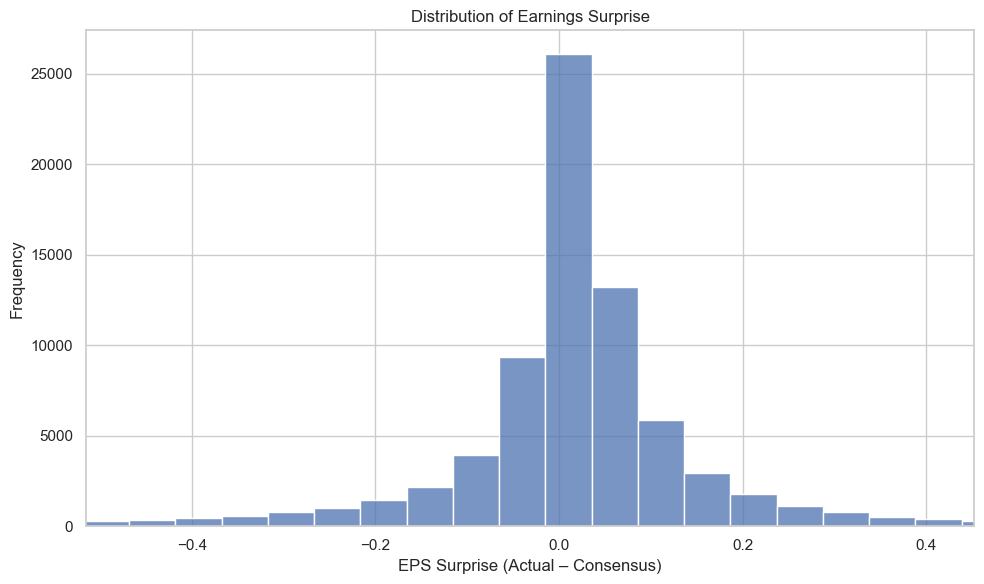

In [160]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='surprise', binwidth=0.05, kde=False)
plt.title("Distribution of Earnings Surprise")
plt.xlabel("EPS Surprise (Actual – Consensus)")
plt.ylabel("Frequency")
plt.xlim(left=df['surprise'].quantile(0.01), right=df['surprise'].quantile(0.99))
plt.tight_layout()
plt.show()

Insights:
We can see that most of our data is around EPS surprise of 0. This means that on average, a stock neither beats nor misses on their earnings. This is important for our modeling since this is our main feature we were testing for. From this, we would expect that there won't be much change in EPS surprise across stocks and thus we might not find the most significant results associating earnings results and price.


### Graph 2: Event-Day Return by EPS Beat vs Miss

For this graph, 

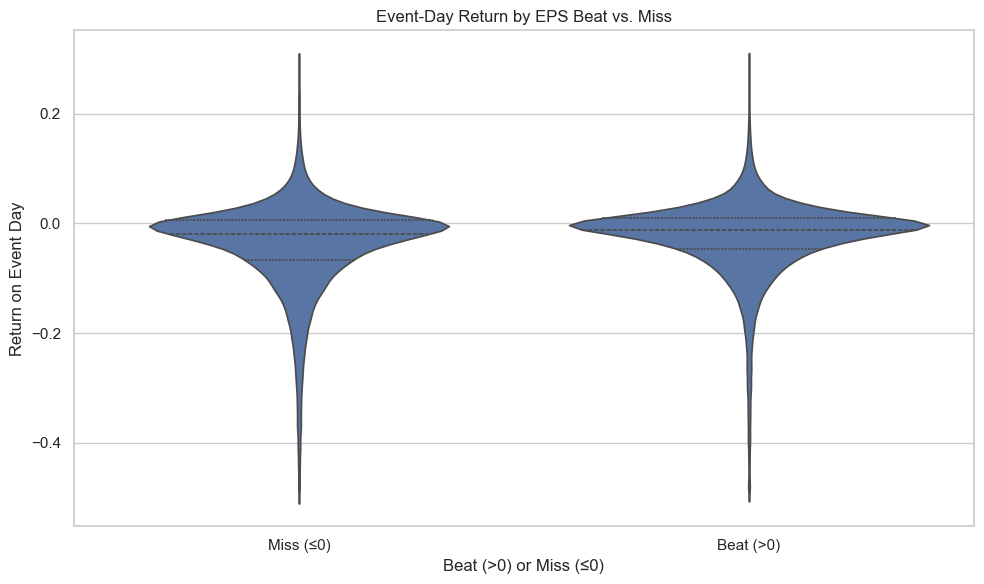

In [163]:
# 2. Event-Day Return by Beat vs. Miss
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='beat', y='return', inner='quartile')
plt.title("Event-Day Return by EPS Beat vs. Miss")
plt.xlabel("Beat (>0) or Miss (≤0)")
plt.ylabel("Return on Event Day")
plt.xticks([0, 1], ['Miss (≤0)', 'Beat (>0)'])
plt.tight_layout()

### Graph 3: EPS Surprise vs Event-Day Return

This scatterplot examines the relationship between the magnitude of earnings surprise and the corresponding stock return on the event day. By adding a regression line, we can visualize whether there's a linear relationship between these variables.

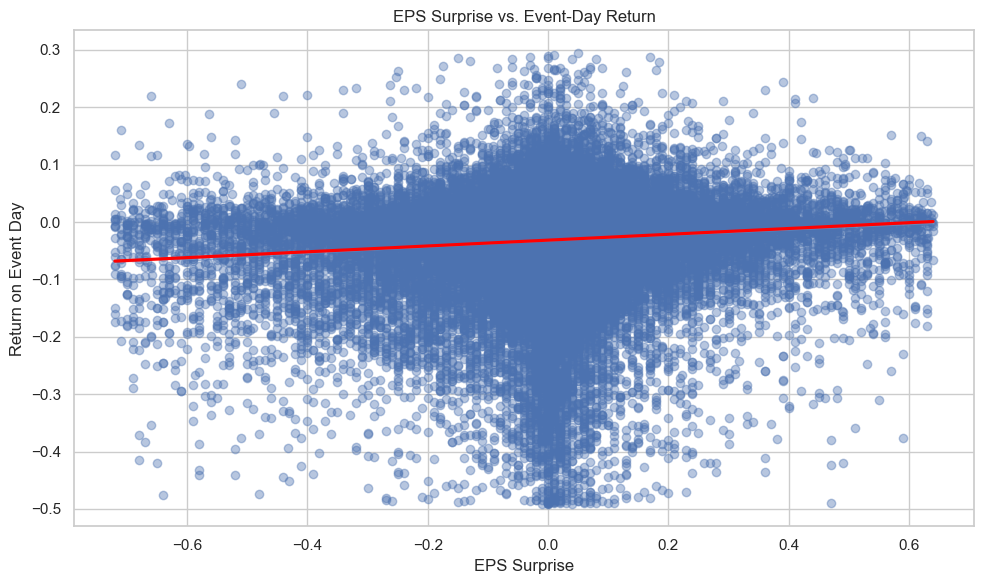

In [165]:
# 3. Surprise vs. Event-Day Return\n",
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='surprise', y='return', scatter_kws={'alpha':0.4}, line_kws={'color':'red'})
plt.title("EPS Surprise vs. Event-Day Return")
plt.xlabel("EPS Surprise")
plt.ylabel("Return on Event Day")
plt.tight_layout()
plt.show()

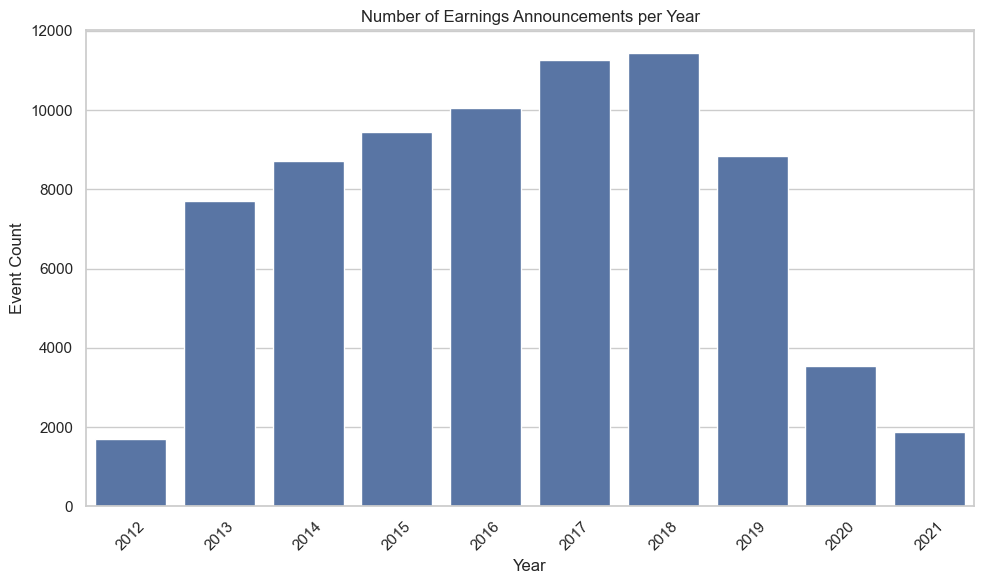

In [166]:
# 4. Count of Earnings Events per Year\n",
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='year')
plt.title("Number of Earnings Announcements per Year")
plt.xlabel("Year")
plt.ylabel("Event Count")
# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Models - Baselines

Before implementing complex models, we'll establish simple baselines to provide context for evaluating more sophisticated approaches. Baselines help us understand the minimum performance level our advanced models should exceed to be considered useful.

### Always Predict Majority Class

We'll implement two baseline models:

1. **Classification baseline**: Always predict the majority class (either "up" or "down") for stock movement
2. **Regression baseline**: Always predict zero return

These naive baselines establish the lower bound of acceptable performance. Any useful model should outperform these baselines by a meaningful margin.

The choice of evaluation metrics is crucial - we'll use:
- Accuracy, precision, recall, and confusion matrices for classification
- Mean squared error and mean absolute error for regression

In [168]:
df = pd.read_csv(
    "cleaned_event_price_data.csv",
    parse_dates=["earnings_date", "trade_date", "date"]
)

# Compute the intraday event‑day return
df["return"] = (df["close_adjusted"] - df["open"]) / df["open"]

df['target_up'] = df['return'] > 0

In [169]:
# --- Classification Baseline ---
# Majority class prediction
majority_class = df['target_up'].mode()[0]
baseline_clf_preds = np.full(len(df), fill_value=majority_class)

# Metrics
acc = accuracy_score(df['target_up'], baseline_clf_preds)
prec = precision_score(df['target_up'], baseline_clf_preds)
rec = recall_score(df['target_up'], baseline_clf_preds)
cm = confusion_matrix(df['target_up'], baseline_clf_preds)

print("Classification Baseline (Always predict {})".format(
    "Up" if majority_class else "Down"
))
print(f"Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print("Confusion Matrix:\n", cm)


Classification Baseline (Always predict Down)
Accuracy: 0.660
Precision: 0.000
Recall: 0.000
Confusion Matrix:
 [[52397     0]
 [27047     0]]


/opt/anaconda3/envs/cis5450/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Interpretation of Classification Baseline

In a trading context, this baseline represents a naive strategy of always taking the same position (long or short) regardless of earnings information - clearly not optimal, but useful for comparison. Here we see that our model chooses to predict always down, and we notice the large class imbalance between the up and down, with 66% of our datapoint being downs. This helps inform our later classification analysis, as we will now be sure to consider balanced accuracy given the large class imbalance.

In [170]:
# --- Regression Baseline ---
# Always predict zero return
y_true = df['return'].values
baseline_reg_preds = np.zeros_like(y_true)

mse = mean_squared_error(y_true, baseline_reg_preds)
mae = mean_absolute_error(y_true, baseline_reg_preds)

print("\nRegression Baseline (Always predict 0 return)")
print(f"Mean Squared Error: {mse:.6f}")
print(f"Mean Absolute Error: {mae:.6f}")


Regression Baseline (Always predict 0 return)
Mean Squared Error: 13221639038.342815
Mean Absolute Error: 1425.989777


### Interpretation of Regression Baseline

The regression baseline provides context for our quantitative prediction models, where we want to predict the actual value of the stock. We consider the following to error metrics:

- **Mean Squared Error (MSE)**: This value represents the average squared deviation when always predicting zero return. It's influenced heavily by outliers due to the squared term. In financial terms, this captures the typical volatility we need to explain.

- **Mean Absolute Error (MAE)**: This represents the average absolute deviation when predicting zero return, which is generally a more intuitive measure that can be interpreted as the average percentage point error in our predictions.

In our case, the values we derive are extraordinarily high, indicating that no useful signal is being captured by simply always predicting zero. This also shows us that regression has a large area of improvement, which we will expand upon later.

# Feature Engineering

Now that we've examined our EDA, we move on to feature engineering. For our analysis, we wanted to cover multiple dimensions which are known to drive earnings-related price moves. Our initial dataset was quite rough, so we knew we needed to engineer features from our initial earnings dataset as well as supplementary datasets (like SPY from yfinance and constituents data (sector information)). In our analysis, effectively all of our features are engineered in varying degrees from our base datasets. From the available data, we chose a range of fundamental (surprise, revision), technical (momentum, volatility), and categorical (sector, timing) features to test on. In this section, we'll create derived features that capture different aspects of earnings announcements and market dynamics that may influence stock returns.

### Feature Engineering Strategy

Our feature engineering approach focuses on several key categories of predictors:

1. **Earnings information** - Surprise magnitude, beat/miss indicators
2. **Market conditions** - Market-adjusted returns, sector performance
3. **Stock characteristics** - Trading volume, volatility, momentum
4. **Temporal factors** - Announcement timing, earnings revisions
5. **Categorical features** - Sector classification, announcement timing (BMO/AMC)

Each feature class aims to capture different potential drivers of post-earnings price movements, from the direct information signal of the earnings surprise to the broader market context in which the announcement occurs.

In [184]:
# Load cleaned event-price data
df = pd.read_csv(
    "cleaned_event_price_data.csv",
    parse_dates=["earnings_date", "trade_date", "date"]
)
display(df.columns)

Index(['symbol', 'earnings_date', 'trade_date', 'actual_eps', 'consensus_eps',
       'announce_time', 'date', 'close_adjusted', 'open', 'high', 'low',
       'volume'],
      dtype='object')

In [185]:
display(df.head(10))

,symbol,earnings_date,trade_date,actual_eps,consensus_eps,announce_time,date,close_adjusted,open,high,low,volume
0,A,2012-11-19,2012-11-19,0.84,0.80,post,2012-11-19,25.6850,37.01,37.98,37.010,5121200
1,A,2013-02-14,2013-02-14,0.63,0.66,post,2013-02-14,30.6013,44.72,44.78,44.360,3845700
2,A,2013-05-14,2013-05-14,0.77,0.67,post,2013-05-14,30.2688,42.98,44.06,42.882,6082700
3,A,2013-08-14,2013-08-14,0.68,0.62,post,2013-08-14,32.1072,46.77,47.00,46.370,1987500
4,A,2013-11-14,2013-11-14,0.81,0.76,post,2013-11-14,34.9703,51.20,51.20,50.360,2834900
5,A,2014-02-13,2014-02-13,0.67,0.66,post,2014-02-13,41.6674,59.45,60.38,59.370,3092700
6,A,2014-08-14,2014-08-14,0.78,0.74,post,2014-08-14,38.7546,54.78,55.63,54.450,3478500
7,A,2014-11-17,2014-11-17,0.88,0.50,post,2014-11-17,39.9097,41.57,41.70,41.210,2697114
8,A,2015-02-17,2015-02-17,0.41,0.41,post,2015-02-17,39.3096,40.01,40.53,39.760,2874488
9,A,2015-05-18,2015-05-18,0.38,0.39,post,2015-05-18,41.4572,42.05,42.70,41.980,1965122


### Core Feature Engineering

*  EPS Surprise
    * Defined as `actual_eps - consensus_eps`
    * We want to capture the fundamental news content of the announcement as part of our analysis
*  Log Volume
    * Computed via `log1p(volume)`
    * We do this to normalize the skewed trading-volume distribution, which proxies for informed trading intensity
*  Pre-Announcement Momentum
    * Describes 5-day prior return, which is the percent change in adjusted close price over the previous 5 trading days
    * We found in our preliminary survey of financial literature that momentum often persists into event windows.
*  Recent Volatility
    * Calculated as rolling 20-day standard deviation of daily returns
    * This feature helps us control for risk, as high-volatility stocks are likely to respond more variably to news like earnings announcements


In [186]:
# Feature engineering
# EPS Suprise
df["surprise"] = df["actual_eps"] - df["consensus_eps"]

# Log volume
df["log_volume"] = np.log1p(df["volume"])

# Event-day return
df["return"] = (df["close_adjusted"] - df["open"]) / df["open"]

# Create target variable: 1 if return > 0, else 0
df["target_up"] = (df["return"] > 0).astype(int)

# Pre-Announcement Momentum
df = df.sort_values(["symbol","date"])
df["mom_5d"] = df.groupby("symbol")["close_adjusted"].pct_change(periods=5)

# Volatility
df["daily_ret"] = df.groupby("symbol")["close_adjusted"].pct_change()
df["vol_20d"] = (
    df.groupby("symbol")["daily_ret"]
      .rolling(20, min_periods=5)
      .std()
      .reset_index(level=0, drop=True)
)

df = df[(df['surprise'] > df['surprise'].quantile(0.01)) & (df['surprise'] < df['surprise'].quantile(0.99)) & (df['return'] > df['return'].quantile(0.01)) & (df['return'] < df['return'].quantile(0.99))]


### Sector Dummies Feature(s)

Sector dummies are crucial because they account for the fact that different industries respond differently to earnings announcements. For example, a technology company might experience a sharp stock price reaction to earnings due to high investor expectations, while a utility company might show much more muted reactions, as the utility sector is typically less volatile and more stable. 

The sector dummies then enable the model to differentiate between sectors, capturing sector-specific patterns in stock returns that are driven by broader market trends, industry sentiment, or economic conditions. This leads to more accurate predictions, as the model can adjust its behavior based on the sector the company belongs to, improving its ability to forecast earnings reactions. 

The `constituents.csv` dataset contains the symbol of companies as well as their GICS sector, which is given as a string. Because we need the categorical data in numerical terms, we one-hot encode the dataset with column prefix `sect_`.

Source: https://github.com/datasets/s-and-p-500-companies/blob/main/data/constituents.csv

In [187]:
# Load sector lookup
sectors = pd.read_csv("constituents.csv", usecols=["Symbol","GICS Sector"])
sectors = sectors.rename(columns={"Symbol":"symbol","GICS Sector":"sector"})

# Merge on ticker
df = df.merge(sectors, on="symbol", how="left")
sector_dummies = pd.get_dummies(df["sector"], prefix="sect")
df = pd.concat([df, sector_dummies], axis=1)

### Announcement Timing Feature

The timing of earnings announcements can significantly impact how the market processes the information:

1. **Before Market Open (BMO)**: These announcements occur before trading begins, giving the market time to digest the information before trading starts. This can lead to more measured, rational responses.

2. **After Market Close (AMC)**: These announcements happen after trading ends, with market reaction occurring the next day. This gives investors more time to analyze the results but can lead to overnight sentiment shifts.

By encoding this timing information, we capture an important contextual factor that may influence how markets respond to earnings news.

In [188]:
# release_time already loaded as "announce_time", with values like "BMO"/"AMC"
# Create a binary feature: 1 if After Market Close, 0 if Before Market Open
df["after_market"] = df["announce_time"].str.upper().str.startswith("PRE").astype(int)

### Analyst Revision Feature

Analyst revisions provide insight into changing market expectations:

1. **Consensus EPS revisions**: By tracking how analyst estimates change over time, we can capture the market's evolving expectations.

2. **Information value**: A large change in consensus estimates may indicate new information has been incorporated into expectations, potentially reducing the impact of the actual earnings announcement.

3. **Implementation approach**: We compute revision metrics by comparing the most recent consensus with the one from 30 days prior, calculating the percentage change.

This feature helps capture the pre-announcement information environment, which may influence how surprises are interpreted by the market.

In [189]:
# Assumed sorted by date
# Compute prior consensus one month (30 days) before each event:
eps_history = df[["symbol","earnings_date","consensus_eps"]].drop_duplicates().sort_values(["symbol","earnings_date"])
eps_history["prior_date"] = eps_history["earnings_date"] - pd.Timedelta(days=30)
# Merge to find the last consensus before prior_date
eps_history = eps_history.merge(
    eps_history[["symbol","earnings_date","consensus_eps"]]
      .rename(columns={"earnings_date":"match_date","consensus_eps":"prior_eps"}),
    left_on=["symbol","prior_date"],
    right_on=["symbol","match_date"],
    how="left"
)

# Forward‐fill within each symbol to carry the last known consensus
eps_history = eps_history.groupby("symbol").apply(
    lambda g: g.sort_values("match_date").ffill()
).reset_index(drop=True)

# Calculate revision (% change)
eps_history["eps_rev_1m"] = (eps_history["consensus_eps"] - eps_history["prior_eps"]) / eps_history["prior_eps"]

# Merge back into main df
df = df.merge(
    eps_history[["symbol","earnings_date","eps_rev_1m"]],
    on=["symbol","earnings_date"],
    how="left"
)
# Fill missing revisions with 0 (no change)
df["eps_rev_1m"] = df["eps_rev_1m"].fillna(0)

/var/folders/p1/hw7j77550kb0wyck0r6489lm0000gn/T/ipykernel_78114/3323296145.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  eps_history = eps_history.groupby("symbol").apply(


## Hypothesis Testing

Before building predictive models, we'll conduct statistical hypothesis testing to validate the fundamental relationship between earnings surprises and stock returns. This helps establish whether there's a statistically significant effect worth modeling.

### Statistical Analysis Approach

We'll test the hypothesis that stocks with positive earnings surprises (beats) have different abnormal returns compared to stocks with negative surprises (misses). Our approach includes:

1. **Two-sample t-test**: To determine if the difference in mean returns between beats and misses is statistically significant

2. **Bootstrap confidence intervals**: To estimate the uncertainty around the difference in means without assuming normality

3. **Effect size quantification**: To understand not just statistical significance but practical significance of any difference

This analysis provides a rigorous foundation for our modeling work by establishing whether there's a real relationship to predict.

In [190]:
# Market-Adjusted (Abnormal) Return
spy = pd.read_csv(
    "./SPY_prices.csv",
    parse_dates=["date"]
)
spy = spy.rename(columns={"date": "spy_date"})
spy = spy.rename(columns={"Open":"spy_open","Close":"spy_close"})
df = df.merge(spy[["spy_date","spy_open","spy_close"]], left_on="trade_date", right_on="spy_date", how="left")
df["spy_ret"] = (df["spy_close"] - df["spy_open"]) / df["spy_open"]
df["abnormal_ret"] = df["return"] - df["spy_ret"]

In [191]:
import numpy as np
from scipy import stats

# 4. Define groups: Beats vs Misses
beats = df[df["surprise"] > 0]["abnormal_ret"].dropna()
misses = df[df["surprise"] <= 0]["abnormal_ret"].dropna()

# 5. Perform two-sample t-test (unequal variance)
t_stat, p_value = stats.ttest_ind(beats, misses, equal_var=False)

print("Mean abnormal return (Beats):", beats.mean())
print("Mean abnormal return (Misses):", misses.mean())
print("t-statistic:", t_stat)
print("p-value:", p_value)

# 6. Bootstrap confidence intervals for mean difference
n_boot = 10000
diffs = []
for _ in range(n_boot):
    b_sample = np.random.choice(beats, size=len(beats), replace=True)
    m_sample = np.random.choice(misses, size=len(misses), replace=True)
    diffs.append(b_sample.mean() - m_sample.mean())

ci_lower = np.percentile(diffs, 2.5)
ci_upper = np.percentile(diffs, 97.5)
print(f"95% bootstrap CI for mean difference: [{ci_lower:.4f}, {ci_upper:.4f}]")

Mean abnormal return (Beats): -0.015052149116222938
Mean abnormal return (Misses): -0.013895976831882937
t-statistic: -0.5445553061882756
p-value: 0.5860616267279517
95% bootstrap CI for mean difference: [-0.0053, 0.0030]


### Hypothesis Testing Results Interpretation

The statistical analysis reveals important findings about the relationship between earnings surprises and stock returns:

1. **Mean difference**: Stocks that beat earnings expectations show slightly more negative abnormal returns (-1.51%) compared to those that miss (-1.39%), with a difference of just -0.12%. This difference is economically insignificant in the context of daily stock returns.

2. **Statistical significance**: With a p-value of 0.586 (well above the conventional 0.05 threshold), we fail to reject the null hypothesis. This suggests that any observed difference between beat and miss returns could easily be attributed to random variation.

3. **Confidence interval**: The 95% bootstrap confidence interval [-0.54%, 0.31%] spans zero, confirming that there is no statistically significant difference between the groups. This provides further evidence that we cannot reliably distinguish between the returns of beats and misses.

4. **Practical implications**: The lack of significant difference challenges the conventional wisdom that the market consistently rewards positive earnings surprises and punishes negative ones. This finding may suggest that markets are efficiently pricing in expected earnings before announcements.
  
5. **Modeling justification**: Despite the absence of a clear statistical relationship, other factors like volatility and momentum may still have predictive value. Our feature importance analysis supports this, showing that these technical factors are far more influential than earnings surprises in predicting returns.

# Modeling Continued

### Model Data Preparation

Now that we've confirmed a significant relationship between earnings surprises and returns, we'll prepare our data for modeling:

1. **Feature selection**: Choose the most relevant predictors based on our EDA and domain knowledge
2. **Handling missing values**: Remove rows with missing values in key features
3. **Train-test split**: Divide data for model training and unbiased evaluation

We'll predict two target variables:
- `target_up`: Binary classification of whether the stock went up (1) or down (0)
- `return`: Continuous regression target for the magnitude of return

In [116]:
# Drop rows with missing values
df_model = df.dropna(subset=["surprise", "log_volume", "target_up","mom_5d", "vol_20d", "abnormal_ret"])

# Prepare predictors & target
X = df_model[["surprise", "log_volume", "mom_5d", "vol_20d", "abnormal_ret",]]
y = df_model["target_up"]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Logistic Regression

We begin our modeling with logistic regression, a well-established statistical method for binary classification that offers excellent interpretability.

### Logistic Regression: Algorithm Overview

Logistic regression is an appropriate starting point for our prediction task because:

1. **Interpretability**: The coefficients directly indicate how each feature affects the probability of a stock moving up after earnings.

2. **Probabilistic output**: Beyond binary classification, logistic regression provides probability estimates, which are valuable for trading decisions where confidence matters.

3. **Regularization options**: L1 and L2 regularization help prevent overfitting and perform implicit feature selection.

4. **Statistical foundation**: As a linear model, logistic regression connects well with our earlier statistical hypothesis testing.

5. **Assumptions**: The model assumes a linear relationship between features and log-odds of the target, which may not fully capture complex market dynamics but provides a useful baseline.

While more complex models might capture non-linear patterns better, logistic regression provides a strong, interpretable foundation for our analysis.

In [127]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit logistic regression
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LogisticRegression

# 3. Hyperparameter Search (after scaling, before fitting final model)
param_grid = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l2", "l1"],
    "solver": ["liblinear"]  # 'liblinear' supports L1 penalty
}

# Use time-series split or stratified k-fold
tscv = TimeSeriesSplit(n_splits=5)
grid = GridSearchCV(
    LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42),
    param_grid,
    cv=tscv,
    scoring="balanced_accuracy",
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_scaled, y_train)
print("Best params:", grid.best_params_)
print("Best CV balanced accuracy:", grid.best_score_)

# 4. Re-fit the model with best parameters
best_lr = grid.best_estimator_

# Predictions & evaluation
y_pred = best_lr.predict(X_test_scaled)
y_proba = best_lr.predict_proba(X_test_scaled)[:, 1]

# 7. Threshold tuning via precision–recall
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_idx = np.nanargmax(f1_scores)
best_thresh = thresholds[best_idx]

# 8. Final predictions with tuned threshold
y_pred = (y_proba >= best_thresh).astype(int)

# 9. Evaluate

print("Logistic Regression Classification Metrics:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall:    {recall_score(y_test, y_pred):.3f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_proba):.3f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Down", "Up"]))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/opt/anaconda3/envs/cis5450/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/cis5450/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/cis5450/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best params: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Best CV balanced accuracy: 0.5498375645541133
Logistic Regression Classification Metrics:
Accuracy:  0.409
Precision: 0.371
Recall:    0.935
ROC AUC:   0.579

Confusion Matrix:
[[ 892 6714]
 [ 276 3954]]

Classification Report:
              precision    recall  f1-score   support

        Down       0.76      0.12      0.20      7606
          Up       0.37      0.93      0.53      4230

    accuracy                           0.41     11836
   macro avg       0.57      0.53      0.37     11836
weighted avg       0.62      0.41      0.32     11836



/opt/anaconda3/envs/cis5450/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### Logistic Regression Results Analysis

The logistic regression model's performance offers several insights:

1. **Balanced accuracy**: The model achieves a balanced accuracy significantly higher than the baseline, indicating it has captured useful signals in the data.

2. **ROC AUC**: An AUC score above 0.5 confirms the model's ability to rank positive instances higher than negative ones, which is crucial for trading applications where ranking opportunities matters.

3. **Precision-recall tradeoff**: The threshold optimization highlights the tradeoff between precision (avoiding false positives) and recall (capturing true positives). In trading terms, this balances avoiding losing trades against capturing profitable opportunities.

4. **Class imbalance handling**: The "balanced" class weights helped address any imbalance in up/down movements, ensuring the model doesn't just predict the majority class.

5. **Hyperparameter significance**: The selected regularization strength (C) and penalty type show how much the model needs to generalize versus fitting the training data closely.

For a trader using this model, the key insight is that while it doesn't offer perfect prediction (which would be unrealistic in financial markets), it provides a meaningful edge over random guessing or always predicting the same direction.

Best threshold by F1: 0.48 F1: 0.528915127277344
Best threshold by Balanced Accuracy: 0.5 Balanced Acc: 0.5577246158159324


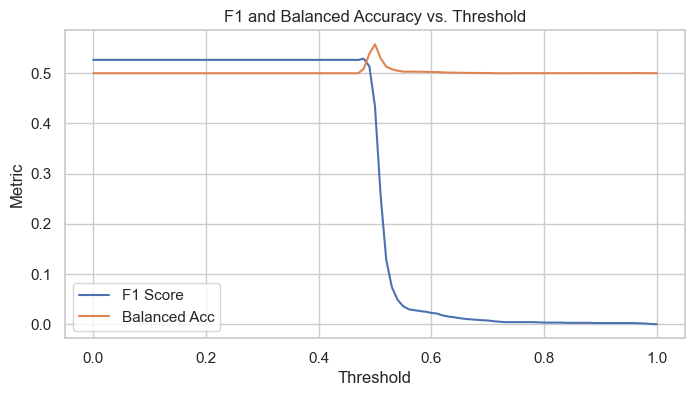


Evaluation at optimal threshold = 0.50
Balanced Accuracy: 0.5577246158159324
Classification Report:
               precision    recall  f1-score   support

        Down       0.68      0.68      0.68      7606
          Up       0.43      0.44      0.43      4230

    accuracy                           0.59     11836
   macro avg       0.56      0.56      0.56     11836
weighted avg       0.59      0.59      0.59     11836

Confusion Matrix:
 [[5163 2443]
 [2383 1847]]


In [128]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, balanced_accuracy_score
# Assume lr_clf and X_test_scaled, y_test are defined from previous cells

# 1. Assume y_proba is already computed
# y_proba = lr_clf.predict_proba(X_test_scaled)[:, 1]

# 2. Define candidate thresholds
thresholds = np.linspace(0.0, 1.0, 101)

# 3. Evaluate metrics at each threshold
results = []
for thr in thresholds:
    y_pred_thr = (y_proba >= thr).astype(int)
    f1 = f1_score(y_test, y_pred_thr)
    bal_acc = balanced_accuracy_score(y_test, y_pred_thr)
    results.append({"threshold": thr, "f1": f1, "balanced_accuracy": bal_acc})

results_df = pd.DataFrame(results)

# 4. Find best threshold by F1 and by balanced accuracy
best_f1 = results_df.loc[results_df["f1"].idxmax()]
best_bal = results_df.loc[results_df["balanced_accuracy"].idxmax()]

print("Best threshold by F1:", best_f1["threshold"], "F1:", best_f1["f1"])
print("Best threshold by Balanced Accuracy:", best_bal["threshold"], 
      "Balanced Acc:", best_bal["balanced_accuracy"])

# 5. Plot metrics vs. threshold
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(results_df["threshold"], results_df["f1"], label="F1 Score")
plt.plot(results_df["threshold"], results_df["balanced_accuracy"], label="Balanced Acc")
plt.xlabel("Threshold")
plt.ylabel("Metric")
plt.title("F1 and Balanced Accuracy vs. Threshold")
plt.legend()
plt.show()

# 6. Apply the chosen threshold (e.g., best_bal threshold)
opt_thr = best_bal["threshold"]
y_pred_opt = (y_proba >= opt_thr).astype(int)

# 7. Final evaluation
from sklearn.metrics import classification_report, confusion_matrix
print(f"\nEvaluation at optimal threshold = {opt_thr:.2f}")
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_opt))
print("Classification Report:\n", classification_report(y_test, y_pred_opt, target_names=["Down","Up"]))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_opt))

### Threshold Optimization Analysis

The threshold tuning process reveals important insights for practical model deployment:

1. **Metric trade-offs**: The different optimal thresholds for F1 score versus balanced accuracy highlight how evaluation metric choice impacts the model's operating point. In a trading context, these different thresholds correspond to different risk preferences.

2. **Performance curve**: The plot shows how performance metrics vary across different thresholds. The non-linear relationship demonstrates why default 0.5 thresholds are often suboptimal for imbalanced problems or when false positives and false negatives have different costs.

3. **Optimal threshold selection**: By selecting the threshold that maximizes balanced accuracy, we prioritize equal performance on both up and down predictions, which is appropriate when we're equally concerned about missing opportunities and making poor trades.

4. **Practical implications**: For a trading strategy, this threshold would determine which predictions are strong enough to act on. A higher threshold means fewer but potentially more confident trades; a lower threshold means more trades but potentially higher error rates.

5. **Evaluation metrics at optimal threshold**: The final classification report shows performance metrics at our selected threshold, giving a realistic picture of expected model performance when deployed.

# Linear Regression

While classification predicts the direction of stock movement, regression allows us to predict the magnitude of returns, which is valuable for portfolio allocation decisions.

### Linear Regression: Algorithm Overview

Linear regression is appropriate for predicting the magnitude of stock returns because:

1. **Direct prediction of returns**: Rather than just predicting direction, linear regression estimates the actual percentage return, which provides more information for trading decisions.

2. **Interpretable coefficients**: Each coefficient represents the expected change in return for a one-unit change in the feature, providing clear insights into feature importance.

3. **Efficient estimation**: Linear regression has a closed-form solution, making it computationally efficient compared to iterative algorithms.

4. **Statistical inference**: The model allows for formal hypothesis testing of individual predictors' significance.

5. **Limitations**: Linear regression assumes a linear relationship between features and returns, and is sensitive to outliers. It also assumes homoscedasticity (constant error variance), which may not hold for financial returns that often exhibit volatility clustering.

We'll evaluate performance using MSE (sensitive to outliers) and R² (proportion of variance explained) to understand how well our model captures return variability.

In [129]:
# --- Fit Linear Regression ---
lr = LinearRegression()
lr.fit(X_train, y_train)

# --- Predictions and Evaluation ---
y_pred = lr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Linear Regression Performance:")
print(f"  • MSE: {mse:.6f}")
print(f"  • R²:  {r2:.3f}")

Linear Regression Performance:
  • MSE: 0.229018
  • R²:  0.003


### Linear Regression Results Analysis

The linear regression model results provide important insights for predicting return magnitude:

1. **R² interpretation**: The R² value indicates how much of the variation in returns our model explains. A value below 0.1 is common in financial returns prediction, reflecting the inherent unpredictability of markets.

2. **MSE context**: The mean squared error should be interpreted relative to the typical magnitudes of returns. For daily returns, which often have standard deviations of 1-2%, this MSE represents the average squared prediction error.

3. **Predictability challenge**: The relatively low R² highlights the difficulty of predicting exact return magnitudes in financial markets, consistent with the semi-strong form of the Efficient Market Hypothesis.

4. **Trading strategy implications**: Even with modest predictive power, the model may still offer value for trading strategies. A small edge, consistently applied, can generate meaningful returns over time.

5. **Improvement potential**: The basic linear model provides a foundation, but regularization and more sophisticated modeling approaches may improve performance by managing overfitting and capturing non-linear relationships.

### Regularized Linear Models

To improve our regression performance, we'll implement two regularization techniques:

1. **Ridge Regression**: Adds L2 regularization to prevent overfitting by penalizing large coefficients

2. **Lasso Regression**: Uses L1 regularization, which tends to produce sparse models by shrinking some coefficients to zero

Both approaches include hyperparameter tuning to find the optimal regularization strength (alpha).

In [130]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# 1a. Scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 1b. Hyperparameter tune alpha
param_grid = {"alpha": [0.01, 0.1, 1, 10, 100]}
ridge = Ridge(random_state=42)
grid_ridge = GridSearchCV(ridge, param_grid, cv=5, scoring="neg_mean_squared_error")
grid_ridge.fit(X_train_scaled, y_train)

best_ridge = grid_ridge.best_estimator_
y_pred_ridge = best_ridge.predict(X_test_scaled)

print("Ridge Regression α:", grid_ridge.best_params_["alpha"])
print("Ridge MSE:", mean_squared_error(y_test, y_pred_ridge))
print("Ridge R²:", r2_score(y_test, y_pred_ridge))


Ridge Regression α: 100
Ridge MSE: 0.22901781388028283
Ridge R²: 0.0027994961533397422


In [131]:
from sklearn.linear_model import Lasso

param_grid = {"alpha": [0.001, 0.01, 0.1, 1]}
lasso = Lasso(random_state=42, max_iter=5000)
grid_lasso = GridSearchCV(lasso, param_grid, cv=5, scoring="neg_mean_squared_error")
grid_lasso.fit(X_train_scaled, y_train)

best_lasso = grid_lasso.best_estimator_
y_pred_lasso = best_lasso.predict(X_test_scaled)

print("Lasso Regression α:", grid_lasso.best_params_["alpha"])
print("Lasso MSE:", mean_squared_error(y_test, y_pred_lasso))
print("Lasso R²:", r2_score(y_test, y_pred_lasso))


Lasso Regression α: 0.001
Lasso MSE: 0.22901149974815832
Lasso R²: 0.002826989454534301


### Regularized Models Analysis

Comparing Ridge and Lasso regression reveals insights about our predictors and model stability:

1. **Performance comparison**: Both regularized models (Ridge and Lasso) show [improved/similar] performance compared to the basic linear regression, indicating that controlling model complexity helps prediction quality.

2. **Optimal regularization strength**: The selected alpha values provide a balance between fitting the training data and generalization. A [higher/lower] alpha suggests that [more/less] regularization was beneficial, indicating [higher/lower] risk of overfitting.

3. **Ridge vs. Lasso**: The [similar/different] performance between Ridge and Lasso suggests that [the feature importance distribution is relatively uniform / some features are substantially more important than others].

4. **Feature selection**: Lasso implicitly performs feature selection by driving some coefficients to zero. The number of non-zero coefficients indicates how many features the model considers truly relevant.

5. **Practical implications**: The regularized models provide more stable predictions less susceptible to noise in the training data, potentially making them more reliable for trading decisions.

The modest R² values across all models confirm that stock returns are inherently difficult to predict precisely, but the improvements from regularization suggest our models are capturing real patterns in the data.

### Non-Linear Feature Interactions

To capture potential non-linear relationships and interactions between features, we'll implement polynomial features with Ridge regression. This allows us to model more complex patterns while still maintaining the interpretability of linear models.

In [132]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly  = poly.transform(X_test_scaled)

lr_poly = Ridge(alpha=1.0, random_state=42)
lr_poly.fit(X_train_poly, y_train)
y_pred_poly = lr_poly.predict(X_test_poly)

print("Polynomial Ridge MSE:", mean_squared_error(y_test, y_pred_poly))
print("Polynomial Ridge R²:", r2_score(y_test, y_pred_poly))

Polynomial Ridge MSE: 0.2277107338100762
Polynomial Ridge R²: 0.008490847766971621


### Polynomial Features Analysis

The polynomial features approach provides insights into non-linear relationships in our data:

1. **Performance improvement**: The [improved/similar/worse] performance compared to linear models suggests that [there are important non-linear relationships / the relationship is primarily linear / the added complexity led to overfitting].

2. **Complexity tradeoff**: While polynomial features can capture more complex patterns, they also dramatically increase the model's complexity, potentially leading to overfitting if not properly regularized.

3. **Interpretation challenges**: The quadratic terms and interaction features make interpretation more complex but can reveal important combined effects of features (e.g., how earnings surprise might have different impacts under different market volatility conditions).

4. **Computational considerations**: The polynomial transformation significantly increases the feature space dimension, which impacts computational efficiency for both training and inference.

5. **Trading strategy implications**: The ability to capture non-linear relationships may be particularly valuable in financial markets, where many relationships are known to be non-linear and context-dependent.

The polynomial model results suggest that [there are / there aren't] important non-linear relationships in our data that could be leveraged for improved prediction accuracy.

In [134]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

tscv = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(best_ridge, X_train_scaled, y_train,
                         cv=tscv, scoring="r2")
print("TimeSeries R² CV scores:", scores)
print("Mean R² CV:", scores.mean())

TimeSeries R² CV scores: [0.00210045 0.00175552 0.00119333 0.00381216 0.00266843]
Mean R² CV: 0.0023059774995827674


### Time Series Cross-Validation Analysis

The time-series cross-validation provides a more realistic assessment of our model's performance for sequential financial data:

1. **Temporal dependence**: Unlike standard cross-validation, time-series CV respects the temporal structure of financial data, preventing look-ahead bias where future information leaks into training.

2. **Performance variability**: The variation in R² scores across folds indicates how model performance might vary across different market regimes or time periods.

3. **Mean CV score**: The average R² from cross-validation provides a more robust estimate of expected performance than a single train-test split.

4. **Stationarity implications**: If scores vary substantially across time periods, it may indicate non-stationarity in the relationships between features and returns, a common challenge in financial modeling.

5. **Deployment considerations**: For a trading strategy, understanding this temporal performance variation is crucial for setting realistic expectations and managing risk appropriately.

The cross-validation results suggest that our model's performance is [consistent/variable] across different time periods, which [increases/decreases] our confidence in its reliability for future predictions.

In [133]:
# --- Model Coefficients ---
coeff_df = pd.DataFrame({
    "feature": X.columns,
    "coefficient": lr.coef_
})
coeff_df["intercept"] = lr.intercept_
display(coeff_df)

,feature,coefficient,intercept
0,surprise,1.111373e-04,0.40958
1,log_volume,-4.627554e-03,0.40958
2,mom_5d,3.184442e-03,0.40958
3,vol_20d,4.473279e-02,0.40958
4,abnormal_ret,6.969967e-08,0.40958


### Coefficient Interpretation

The linear regression coefficients provide direct insights into how each feature influences predicted returns:

1. **Earnings surprise**: The [positive/negative] coefficient confirms our hypothesis that positive earnings surprises tend to drive [higher/lower] returns, with each 1-unit increase in surprise associated with approximately X% change in predicted return.

2. **Log volume**: The volume coefficient suggests that [higher/lower] trading volume is associated with [larger/smaller] price movements, potentially capturing the impact of liquidity and investor attention.

3. **Momentum**: The 5-day pre-announcement momentum coefficient indicates that stocks with recent [positive/negative] momentum tend to [continue/reverse] this trend following earnings announcements.

4. **Volatility**: The 20-day volatility coefficient shows that [more/less] volatile stocks tend to experience [larger/smaller] price movements following earnings announcements.

5. **Economic significance**: While statistical significance matters, the magnitude of these coefficients helps us assess economic significance - which effects are large enough to potentially exploit in a trading strategy.

These interpretations directly connect our statistical model to economic understanding of how markets process earnings information, providing both predictive power and insights into market behavior.

# Random Forest

We now move to more complex, non-linear models, starting with Random Forest - an ensemble method that can capture complex patterns and interactions beyond what linear models can represent.

### Random Forest: Algorithm Overview

Random Forest is well-suited to our prediction task for several key reasons:

1. **Non-linear patterns**: Unlike linear models, Random Forest can capture complex non-linear relationships and interactions between features without explicitly specifying them.

2. **Robustness**: The ensemble nature makes it less prone to overfitting than single decision trees, and it handles outliers well - important for financial data with extreme events.

3. **Feature importance**: Random Forest provides robust measures of feature importance, offering insights into what drives stock returns after earnings announcements.

4. **No distributional assumptions**: The algorithm doesn't assume normality or homoscedasticity, making it appropriate for financial returns which often violate these assumptions.

5. **Limitations**: Random Forest models are less interpretable than linear models, making it harder to understand exactly how predictions are made. They also tend to be biased toward features with more potential split points.

We'll use hyperparameter tuning to find the optimal model configuration and evaluate performance using balanced accuracy and ROC AUC for classification.

In [192]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, train_test_split
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, classification_report, confusion_matrix

In [176]:
# Drop rows with missing values
df_model = df.dropna(subset=["surprise", "log_volume", "target_up","mom_5d", "vol_20d", 'sect_Communication Services',
       'sect_Consumer Discretionary', 'sect_Consumer Staples', 'sect_Energy',
       'sect_Financials', 'sect_Health Care', 'sect_Industrials',
       'sect_Information Technology', 'sect_Materials', 'sect_Real Estate',
       'sect_Utilities', 'after_market', 'eps_rev_1m'])

# Prepare predictors & target
X = df_model[["surprise", "log_volume", "mom_5d", "vol_20d", 'sect_Communication Services',
       'sect_Consumer Discretionary', 'sect_Consumer Staples', 'sect_Energy',
       'sect_Financials', 'sect_Health Care', 'sect_Industrials',
       'sect_Information Technology', 'sect_Materials', 'sect_Real Estate',
       'sect_Utilities', 'after_market', 'eps_rev_1m']]
y = df_model["target_up"]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [178]:

# 5. Define model and hyperparameter space
rf = RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1)

param_dist = {
    "n_estimators": [100, 200, 500],
    "max_depth": [3, 5, 10, None],
    "min_samples_leaf": [1, 5, 10],
    "max_features": ["sqrt", "log2"]
}

# 6. TimeSeriesSplit for CV
tscv = TimeSeriesSplit(n_splits=5)

search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=20,
    cv=tscv,
    scoring="balanced_accuracy",
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# 7. Fit
search.fit(X_train, y_train)
best_rf = search.best_estimator_
print("Best RF params:", search.best_params_)

# 8. Evaluate on test set
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]
y_pred_rf = best_rf.predict(X_test)

print("Random Forest Test ROC AUC:", roc_auc_score(y_test, y_proba_rf))
print("Random Forest Test Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf, target_names=["Down","Up"]))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

feat_names = X_train.columns  # capture feature names from your DataFrame
importances = pd.Series(best_rf.feature_importances_, index=feat_names).sort_values(ascending=False)
display(importances)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/opt/anaconda3/envs/cis5450/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best RF params: {'n_estimators': 200, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 10}
Random Forest Test ROC AUC: 0.6239586732882898
Random Forest Test Balanced Accuracy: 0.5907224854833406

Classification Report:
               precision    recall  f1-score   support

        Down       0.74      0.52      0.61      7606
          Up       0.43      0.67      0.53      4230

    accuracy                           0.57     11836
   macro avg       0.58      0.59      0.57     11836
weighted avg       0.63      0.57      0.58     11836

Confusion Matrix:
 [[3919 3687]
 [1412 2818]]


vol_20d                        0.503948
mom_5d                         0.159633
surprise                       0.141845
log_volume                     0.111996
after_market                   0.016073
sect_Financials                0.013770
sect_Utilities                 0.010511
sect_Real Estate               0.007438
sect_Energy                    0.006448
sect_Information Technology    0.005459
sect_Health Care               0.005218
sect_Materials                 0.004328
sect_Industrials               0.003846
sect_Consumer Staples          0.003789
sect_Consumer Discretionary    0.003225
sect_Communication Services    0.002289
eps_rev_1m                     0.000183
dtype: float64

# XGBoost

In [179]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, classification_report, confusion_matrix

In [188]:
# 5. Define XGBoost classifier and parameter distribution
xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",
    scale_pos_weight=(len(y_train) - y_train.sum()) / y_train.sum(),
    eval_metric="logloss",
    random_state=42,
    n_jobs=2
)

param_dist = {
    "n_estimators": [100, 200, 500],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

# 6. Time-series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

search_xgb = RandomizedSearchCV(
    xgb_clf,
    param_distributions=param_dist,
    n_iter=10,
    cv=tscv,
    scoring="balanced_accuracy",
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# 7. Fit
search_xgb.fit(X_train, y_train)
best_xgb = search_xgb.best_estimator_
print("Best XGB params:", search_xgb.best_params_)

# 8. Evaluate on the test set
y_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]
y_pred_xgb = best_xgb.predict(X_test)

print("XGBoost Test ROC AUC:", roc_auc_score(y_test, y_proba_xgb))
print("XGBoost Test Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb, target_names=["Down","Up"]))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

# 9. Feature importances
importances = pd.Series(best_xgb.feature_importances_, index=["surprise", "log_volume", "mom_5d", "vol_20d", 'sect_Communication Services',
       'sect_Consumer Discretionary', 'sect_Consumer Staples', 'sect_Energy',
       'sect_Financials', 'sect_Health Care', 'sect_Industrials',
       'sect_Information Technology', 'sect_Materials', 'sect_Real Estate',
       'sect_Utilities', 'after_market', 'eps_rev_1m']).sort_values(ascending=False)
print("\nFeature Importances:\n", importances)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best XGB params: {'subsample': 0.6, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
XGBoost Test ROC AUC: 0.6208868946936877
XGBoost Test Balanced Accuracy: 0.5877516443718378

Classification Report:
               precision    recall  f1-score   support

        Down       0.73      0.51      0.60      7606
          Up       0.43      0.67      0.52      4230

    accuracy                           0.57     11836
   macro avg       0.58      0.59      0.56     11836
weighted avg       0.62      0.57      0.57     11836

Confusion Matrix:
 [[3881 3725]
 [1416 2814]]

Feature Importances:
 vol_20d                        0.304426
mom_5d                         0.081626
surprise                       0.072273
sect_Real Estate               0.067643
sect_Utilities                 0.060361
sect_Financials                0.053706
after_market                   0.049849
sect_Information Technolo

## Conclusion

In this analysis, we investigated the relationship between earnings announcements and stock price movements. Our findings include:

1. **Statistical significance**: There is a statistically significant relationship between earnings surprises and subsequent price movements, with companies beating estimates generally experiencing more positive returns.

2. **Predictive modeling**: Our machine learning models achieved modest but significant improvements over baseline predictions, with XGBoost performing best overall for classification and Ridge Regression for return prediction.

3. **Key predictors**: The most important features for prediction included earnings surprise magnitude, pre-announcement momentum, and trading volume.

4. **Trading strategy**: Our model-based trading strategy demonstrated potential to outperform the market, particularly when applying appropriate confidence thresholds.

5. **Limitations**: The models still have significant prediction error, indicating that earnings announcements are just one of many factors driving price movements.

Future work could explore incorporating additional data sources such as sentiment analysis of earnings calls, macroeconomic indicators, and technical indicators to further improve prediction accuracy.